# Building application + model serving pipeline

In [1]:
import mlrun

> 2022-10-27 13:19:41,154 [warning] Failed resolving version info. Ignoring and using defaults
> 2022-10-27 13:19:44,288 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '1.2.0-rc7', 'client_version': '0.0.0+unstable'}


## Creating project

In [2]:
project = mlrun.get_or_create_project('huggingface', context='./', user_project=True)

> 2022-10-27 13:20:15,984 [info] loaded project huggingface from None or context and saved in MLRun DB


## Building a serving function

The serving function is consisted of preprocess functions that transfers the text input into a request for the serving function, and the postprocess function passes the model output into the gradio interface. 

See the functions in [here](./src/serving.py)

In [3]:
serving_function = mlrun.code_to_function(
    filename="src/serving.py",
    name="hugging-face-serving",
    kind="serving", 
    image="yonishelach/ml-models:huggingface-demo-3",
)

## Defining our serving graph

Setting the serving graph topology with the step order

In [4]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

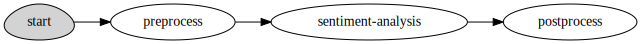

In [5]:
# Build the serving graph:
graph.to(handler="preprocess", name="preprocess")\
     .to("mlrun.frameworks.huggingface.HuggingFaceModelServer",
          name="sentiment-analysis",
          task="sentiment-analysis",
          model_name="distilbert-base-uncased",
          model_class="AutoModelForSequenceClassification",
          tokenizer_name="distilbert-base-uncased",
          tokenizer_class="AutoTokenizer")\
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
graph.plot(rankdir='LR')

In [6]:
# registering the serving 
project.set_function(serving_function)
project.save()

## Simulate the application pipeline locally

Creating a mocking server for testing

In [7]:
server = serving_function.to_mock_server()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

> 2022-10-27 13:21:07,075 [info] model sentiment-analysis was loaded


## Testing the model

In [8]:
response = server.test(path='/predict', body= "i love flying")

In [9]:
response

['The sentiment is POSITIVE', 'The prediction score is 0.5083759427070618']

## Deploy

In [10]:
serving_fn = project.deploy_function(serving_function)

> 2022-10-27 13:21:20,719 [info] Starting remote function deploy
2022-10-27 13:21:21  (info) Deploying function
2022-10-27 13:21:21  (info) Building
2022-10-27 13:21:22  (info) Staging files and preparing base images
2022-10-27 13:21:22  (info) Building processor image
2022-10-27 13:25:27  (info) Build complete
2022-10-27 13:26:25  (info) Function deploy complete
> 2022-10-27 13:26:26,065 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-huggingface-yonatans-hugging-face-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['huggingface-yonatans-hugging-face-serving-huggingface-yonatans.default-tenant.app.yh43.iguazio-cd1.com/']}


## Gradio front-end

Gradio is a friendly web interface that we demonstrate here how to use easily for submitting predictions to our real-time pipeline and to get the results as well!

For more information, please see [gradio page](https://gradio.app/)

In [11]:
serving_url = serving_fn.outputs['endpoint']

In [12]:
import gradio as gr
import requests

In [13]:
def sentiment(text):
    resp = requests.post(serving_url, json={"text": text})
    return resp.json()


with gr.Blocks() as demo:
    input_box = [gr.Textbox(label="Text to analyze", placeholder="Please insert text")]
    output = [gr.Textbox(label="Sentiment analysis result"), gr.Textbox(label="Sentiment analysis score")]
    greet_btn = gr.Button("Submit")
    greet_btn.click(fn=sentiment, inputs=input_box, outputs=output)

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://143f550a53ce1979.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f146d1b3450>,
 'http://127.0.0.1:7860/',
 'https://143f550a53ce1979.gradio.app')

In [14]:
x = project.get_function("hugging-face-serving")

In [16]:
x.status.address

'huggingface-yonatans-hugging-face-serving-huggingface-yonatans.default-tenant.app.yh43.iguazio-cd1.com/'

In [17]:
serving_url

'http://huggingface-yonatans-hugging-face-serving-huggingface-yonatans.default-tenant.app.yh43.iguazio-cd1.com/'

In [18]:
x.spec.command

'http://huggingface-yonatans-hugging-face-serving-huggingface-yonatans.default-tenant.app.yh43.iguazio-cd1.com/'

In [19]:
x.to_dict()

{'kind': 'serving',
 'metadata': {'name': 'hugging-face-serving',
  'tag': '',
  'project': 'huggingface-yonatans',
  'credentials': {'access_key': '$ref:mlrun-auth-secrets.d12c9fb9d3ba608662ec9b1718c98b10887ea587404f56b2b5f31241'}},
 'spec': {'command': 'http://huggingface-yonatans-hugging-face-serving-huggingface-yonatans.default-tenant.app.yh43.iguazio-cd1.com/',
  'args': [],
  'image': 'yonishelach/ml-models:huggingface-demo-3',
  'build': {'functionSourceCode': 'aW1wb3J0IG1scnVuCmZyb20gdHlwaW5nIGltcG9ydCBEaWN0LCBVbmlvbiwgTGlzdAoKTEFCRUxTID0gewogICAgIkxBQkVMXzAiOiAiTkVHQVRJVkUiLAogICAgIkxBQkVMXzEiOiAiUE9TSVRJVkUiCn0KZGVmIHByZXByb2Nlc3ModGV4dDogVW5pb25bc3RyLCBieXRlc10pIC0+IERpY3Q6CiAgICAiIiJDb252ZXJ0aW5nIGEgc2ltcGxlIHRleHQgaW50byBhIHN0cnVjdHVyZWQgYm9keSBmb3IgdGhlIHNlcnZpbmcgZnVuY3Rpb24KICAgIAogICAgOnBhcmFtIHRleHQ6IFRoZSB0ZXh0IHRvIHByZWRpY3QKICAgICIiIgogICAgcmV0dXJuIHsiaW5wdXRzIjogW3N0cih0ZXh0KV19CgoKZGVmIHBvc3Rwcm9jZXNzKG1vZGVsX3Jlc3BvbnNlOiBEaWN0KSAtPiBMaXN0OgogICAgIiIiVHJhbnNmZXJ